In [1]:
# Required imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [2]:
# Load the dataset
df = pd.read_csv('final_combined_dataset.csv')
# Display first few rows to understand the structure
df.head()

,sentence,emotion,dataset_source,Sentiment_Score,POS_Tags,TF_IDF,GloVe_Embeddings,PERSON,ORG,GPE,...,Num_PERSON,Num_ORG,Num_GPE,Num_LOC,Num_NORP,Has_PERSON,Has_ORG,Has_GPE,Has_LOC,Has_NORP
0,That game hurt.,sadness,GoEmotions,-0.5267,DET NOUN VERB PUNCT,"{'that': 0.2117178295838464, 'game': 0.4331049...","[0.111194666666667, 0.135607333333333, -0.1884...",NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
1,"You do right, if you don't care then fuck 'em!",neutral,GoEmotions,0.1316,PRON AUX ADV PUNCT SCONJ PRON AUX PART VERB AD...,"{'you': 0.17934545532404167, 'do': 0.146177028...","[-0.060132625000000, 0.015059875000000, -0.370...",NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
2,Man I love reddit.,happiness,GoEmotions,0.6369,INTJ PRON VERB PROPN PUNCT,"{'man': 0.30802558559831167, 'love': 0.2604358...","[0.051240000000000, 0.382370000000000, -0.2492...",NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
3,"Etenia was nowhere near them, he was by the Fa...",neutral,GoEmotions,0.0000,PROPN AUX ADV ADP PRON PUNCT PRON AUX ADP DET ...,"{'etenia': 0.2851264325068868, 'was': 0.262869...","[0.032060428571429, 0.113800000000000, -0.1042...",NaN,Falcon,Etenia,...,0.0,1.0,1.0,0.0,0.0,0,1,1,0,0
4,Right? Considering it's such an important docu...,happiness,GoEmotions,0.6239,INTJ PUNCT VERB PRON AUX DET DET ADJ NOUN PUNC...,"{'right': 0.11235461457751392, 'the': 0.098552...","[0.001577235294118, 0.045637117647059, -0.2592...",NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0


In [3]:
# Map emotions to their respective categories
emotion_mapping = {
    'sadness': 1,
    'anger': 2,
    'disgust': 3,
    'fear': 4,
    'surprise': 5,
    'happiness': 6,
    'neutral': 7
}

# Make sure emotions are correctly mapped
df['emotion_id'] = df['emotion'].map(lambda x: emotion_mapping.get(x, 0))

In [4]:
print(df['sentence'].apply(type).value_counts())

# Convert all values in the sentence column to strings
df['sentence'] = df['sentence'].astype(str)

# Now proceed with your tokenizer
MAX_SEQUENCE_LENGTH = 120
VOCAB_SIZE = 15000

# Initialize tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df['sentence'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['sentence'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

sentence
<class 'str'>      463229
<class 'float'>         1
Name: count, dtype: int64


In [5]:
# Prepare labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['emotion'])
num_classes = len(label_encoder.classes_)
y = tf.keras.utils.to_categorical(encoded_labels)

print(f"Number of classes: {num_classes}")
print(f"Class mapping: {dict(zip(label_encoder.classes_, range(num_classes)))}")

Number of classes: 7
Class mapping: {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}


In [6]:
# Extract features - handle potential issues safely
# Sentiment Score
sentiment_features = df['Sentiment_Score'].fillna(0).values.reshape(-1, 1)

# Entity features
entity_cols = ['Num_PERSON', 'Num_ORG', 'Num_GPE', 'Num_LOC', 'Num_NORP', 
               'Has_PERSON', 'Has_ORG', 'Has_GPE', 'Has_LOC', 'Has_NORP']
for col in entity_cols:
    if col in df.columns:
        df[col] = df[col].fillna(0)
entity_features = df[entity_cols].values if all(col in df.columns for col in entity_cols) else np.zeros((len(df), len(entity_cols)))

# Function to safely convert string representations to Python objects
def safe_eval(x):
    if pd.isna(x):
        return []
    if isinstance(x, str):
        try:
            return eval(x)
        except:
            return []
    return []

# Process POS Tags
df['POS_Tags_list'] = df['POS_Tags'].apply(safe_eval)
  # Fixed size for simplicity

# Process TF-IDF
df['TF_IDF_list'] = df['TF_IDF'].apply(safe_eval)
 # Fixed size for simplicity

# Process GloVe Embeddings
df['GloVe_list'] = df['GloVe_Embeddings'].apply(safe_eval)
 # Fixed size for simplicity

In [7]:
# Convert features to uniform numpy arrays
# POS Tags processing
# Calculate maximum length for POS tags
pos_max_len = max([len(tags) if isinstance(tags, list) else 0 for tags in df['POS_Tags_list']])
pos_features = np.zeros((len(df), pos_max_len))
for i, tags in enumerate(df['POS_Tags_list']):
    if isinstance(tags, list) and len(tags) > 0:
        for j, tag in enumerate(tags[:pos_max_len]):
            if j < pos_max_len:
                # Simple hash-based encoding
                pos_features[i, j] = hash(str(tag)) % 100

# TF-IDF processing - handle both dictionary and list formats
# Calculate maximum length for TF-IDF features
tfidf_max_len = max([len(tfidf) if isinstance(tfidf, (list, dict)) else 0 for tfidf in df['TF_IDF_list']])
tfidf_features = np.zeros((len(df), tfidf_max_len))
for i, tfidf in enumerate(df['TF_IDF_list']):
    if isinstance(tfidf, dict) and len(tfidf) > 0:
        values = list(tfidf.values())
        for j, val in enumerate(values[:tfidf_max_len]):
            if j < tfidf_max_len:
                tfidf_features[i, j] = float(val)
    elif isinstance(tfidf, list) and len(tfidf) > 0:
        for j, val in enumerate(tfidf[:tfidf_max_len]):
            if j < tfidf_max_len:
                tfidf_features[i, j] = float(val)

# GloVe embeddings processing
# Calculate maximum length for GloVe embeddings
glove_max_len = max([len(glove) if isinstance(glove, list) else 0 for glove in df['GloVe_list']])
glove_features = np.zeros((len(df), glove_max_len))
for i, glove in enumerate(df['GloVe_list']):
    if isinstance(glove, list) and len(glove) > 0:
        for j, val in enumerate(glove[:glove_max_len]):
            if j < glove_max_len:
                try:
                    glove_features[i, j] = float(val)
                except (ValueError, TypeError):
                    pass  # Skip values that can't be converted to float

In [8]:
# Check shapes
print(f"Padded sequences shape: {padded_sequences.shape}")
print(f"Sentiment features shape: {sentiment_features.shape}")
print(f"Entity features shape: {entity_features.shape}")
print(f"POS features shape: {pos_features.shape}")
print(f"TF-IDF features shape: {tfidf_features.shape}")
print(f"GloVe features shape: {glove_features.shape}")

Padded sequences shape: (463230, 120)
Sentiment features shape: (463230, 1)
Entity features shape: (463230, 10)
POS features shape: (463230, 0)
TF-IDF features shape: (463230, 173)
GloVe features shape: (463230, 300)


In [12]:
# First, let's load the test dataset
test_df = pd.read_csv('group_24_url1.csv')

# Display a sample of the test data
test_df.head()

,Start Time,End Time,Sentence,Corrected Sentence,Translation,Emotion,Intensity
0,"00:00:00,000","00:00:15,000",София. В жилищен комплекс Зона Б-5 живеят Лиля...,София. В жилищен комплекс Зона Б-5 живеят Лиля...,Sofia. Lilyana Georgieva and her 13-year-old d...,neutral,neutral
1,"00:00:15,000","00:00:22,000",Откакто бащата на Велина изоставя семейството ...,Откакто бащата на Велина изоставя семейството ...,Ever since Velina's father abandoned her famil...,sadness,moderate
2,"00:00:22,000","00:00:27,000","Почти няма желание, което Лиляна да не изпълня...","Почти няма желание, което Лиляна да не изпълня...",There is almost no desire that Liliana does no...,caring,intense
3,"00:00:27,000","00:00:35,000",Велина много тежко преживя разявата ни с бащай...,Велина много тежко преживя разявата ни с бащай...,Velina has a very difficult time to make a sta...,disappointment,intense
4,"00:00:35,000","00:00:43,000","Тя много страдаше, много плачеше. Аз по някакъ...","Тя много страдаше, много плачеше. Аз по някакъ...","She suffered a lot, crying a lot. I somehow wa...",grief,intense


In [15]:
# Complete emotion mapping for all emotions in the test dataset
complete_emotion_mapping = {
    "happiness": [
        "joy", "optimism", "approval", "pride", "gratitude",
        "love", "excitement", "caring", "relief", "admiration",
        "amusement", "desire"
    ],
    "sadness": [
        "disappointment", "remorse", "grief", "sadness"
    ],
    "anger": [
        "anger", "annoyance", "disapproval"
    ],
    "disgust": [
        "disgust", "embarrassment"  # Added embarrassment
    ],
    "fear": [
        "fear", "nervousness"
    ],
    "surprise": [
        "surprise", "realization", "confusion", "curiosity"  # Added confusion and curiosity
    ],
    "neutral": [
        "neutral"
    ]
}

# Create a flat mapping dictionary for easy lookup
emotion_to_category = {}
for category, emotions in complete_emotion_mapping.items():
    for emotion in emotions:
        emotion_to_category[emotion] = category

# Apply the mapping to convert granular emotions to main categories
test_df['main_emotion'] = test_df['Emotion'].map(emotion_to_category)

# Check for any unmapped emotions
unmapped = test_df[test_df['main_emotion'].isna()]['Emotion'].unique()
if len(unmapped) > 0:
    print(f"Warning: The following emotions were not mapped: {unmapped}")
    # Assign unmapped emotions to neutral or another appropriate category
    test_df['main_emotion'] = test_df['main_emotion'].fillna('neutral')

# Compare distribution of original emotions vs. mapped main emotions
print("\nOriginal emotion distribution:")
print(test_df['Emotion'].value_counts())
print("\nMapped main emotion distribution:")
print(test_df['main_emotion'].value_counts())


Original emotion distribution:
Emotion
neutral           327
annoyance         114
confusion          77
disapproval        72
curiosity          66
optimism           49
caring             44
fear               34
anger              31
disappointment     28
sadness            24
realization        18
relief             16
remorse            15
desire             14
approval           14
admiration         13
love               10
nervousness         8
excitement          7
surprise            7
joy                 6
grief               5
gratitude           5
pride               4
embarrassment       2
amusement           2
disgust             2
Name: count, dtype: int64

Mapped main emotion distribution:
main_emotion
neutral      354
anger        217
happiness    184
surprise     168
sadness       72
fear          42
disgust        4
Name: count, dtype: int64


In [16]:
# Manually assign the exact label encoding to match your specification
# sadness = 1, anger = 2, disgust = 3, fear = 4, surprise = 5, happiness = 6, neutral = 7
emotion_to_id = {
    'sadness': 1,
    'anger': 2,
    'disgust': 3,
    'fear': 4,
    'surprise': 5,
    'happiness': 6,
    'neutral': 7
}

# Assign numeric label (starting from 0 for model compatibility)
test_df['emotion_id'] = test_df['main_emotion'].map(emotion_to_id)
test_df['emotion_id'] = test_df['emotion_id'] - 1  # Adjust to 0-based indexing for model

# Verify mapping has been applied correctly
print("\nEmotion to ID mapping:")
for emotion, id_val in emotion_to_id.items():
    print(f"{emotion}: {id_val} (adjusted for model: {id_val-1})")

print("\nDistribution of numeric emotion IDs:")
print(test_df['emotion_id'].value_counts().sort_index())


Emotion to ID mapping:
sadness: 1 (adjusted for model: 0)
anger: 2 (adjusted for model: 1)
disgust: 3 (adjusted for model: 2)
fear: 4 (adjusted for model: 3)
surprise: 5 (adjusted for model: 4)
happiness: 6 (adjusted for model: 5)
neutral: 7 (adjusted for model: 6)

Distribution of numeric emotion IDs:
emotion_id
0     72
1    217
2      4
3     42
4    168
5    184
6    354
Name: count, dtype: int64


In [17]:
# Ensure label_encoder matches the exact order specified
# This is crucial for the model to interpret the labels correctly
class_order = ['sadness', 'anger', 'disgust', 'fear', 'surprise', 'happiness', 'neutral']
label_encoder = LabelEncoder()
label_encoder.fit(class_order)

# Verify the label encoder has the correct mapping
print("Label encoder classes:", label_encoder.classes_)
print("Label encoder transform example:", label_encoder.transform(class_order))

Label encoder classes: ['anger' 'disgust' 'fear' 'happiness' 'neutral' 'sadness' 'surprise']
Label encoder transform example: [5 0 1 2 6 3 4]


In [18]:
# Create one-hot encoded labels matching your exact specification
num_classes = len(emotion_to_id)
test_labels = test_df['emotion_id'].values
test_y = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)

# Verify the encoding
print("\nEncoded test labels shape:", test_y.shape)
print("Main emotion to numeric mapping (adjusted for model):", 
      dict(zip(emotion_to_id.keys(), range(num_classes))))


Encoded test labels shape: (1041, 7)
Main emotion to numeric mapping (adjusted for model): {'sadness': 0, 'anger': 1, 'disgust': 2, 'fear': 3, 'surprise': 4, 'happiness': 5, 'neutral': 6}


In [19]:
# Preprocess the text data from the test set
# Use the 'Corrected Sentence' column if available, otherwise 'Sentence'
text_column = 'Corrected Sentence' if 'Corrected Sentence' in test_df.columns else 'Sentence'

# Convert sentences to sequences using the same tokenizer as training
test_sequences = tokenizer.texts_to_sequences(test_df[text_column].astype(str))
test_padded_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

print("Test sequences shape:", test_padded_sequences.shape)

Test sequences shape: (1041, 120)


In [20]:
# Create dummy features for the test set
# These should match the expected shapes from the training set
test_sentiment_features = np.zeros((len(test_df), sentiment_features.shape[1]))
test_entity_features = np.zeros((len(test_df), entity_features.shape[1]))
test_pos_features = np.zeros((len(test_df), pos_features.shape[1]))
test_tfidf_features = np.zeros((len(test_df), tfidf_features.shape[1]))
test_glove_features = np.zeros((len(test_df), glove_features.shape[1]))

# If the test dataset has intensity scores, we can use those for sentiment
if 'Intensity' in test_df.columns:
    test_sentiment_features = test_df['Intensity'].values.reshape(-1, 1)

# Now we have all the required inputs for the test set
print("Test features prepared with shapes:")
print(f"Text: {test_padded_sequences.shape}")
print(f"Sentiment: {test_sentiment_features.shape}")
print(f"Entity: {test_entity_features.shape}")
print(f"POS: {test_pos_features.shape}")
print(f"TF-IDF: {test_tfidf_features.shape}")
print(f"GloVe: {test_glove_features.shape}")

Test features prepared with shapes:
Text: (1041, 120)
Sentiment: (1041, 1)
Entity: (1041, 10)
POS: (1041, 0)
TF-IDF: (1041, 173)
GloVe: (1041, 300)


### Model training

In [29]:
# Split the data
X_train_text, X_test_text, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, random_state=42, stratify=y
)

# Split other features
X_train_sentiment, X_test_sentiment, _, _ = train_test_split(
    sentiment_features, y, test_size=0.2, random_state=42, stratify=y
)

X_train_entity, X_test_entity, _, _ = train_test_split(
    entity_features, y, test_size=0.2, random_state=42, stratify=y
)

X_train_pos, X_test_pos, _, _ = train_test_split(
    pos_features, y, test_size=0.2, random_state=42, stratify=y
)

X_train_tfidf, X_test_tfidf, _, _ = train_test_split(
    tfidf_features, y, test_size=0.2, random_state=42, stratify=y
)

X_train_glove, X_test_glove, _, _ = train_test_split(
    glove_features, y, test_size=0.2, random_state=42, stratify=y
)

In [31]:
# Create the model architecture
def build_emotion_classifier():
    # Text input
    text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input')
    embedding_layer = Embedding(VOCAB_SIZE, 300)(text_input)
    lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)
    lstm_layer = Bidirectional(LSTM(32))(lstm_layer)
    
    # Sentiment features input
    sentiment_input = Input(shape=(sentiment_features.shape[1],), name='sentiment_input')
    
    # Entity features input
    entity_input = Input(shape=(entity_features.shape[1],), name='entity_input')
    entity_dense = Dense(16, activation='relu')(entity_input)
    
    # POS features input
    pos_input = Input(shape=(pos_features.shape[1],), name='pos_input')
    pos_dense = Dense(16, activation='relu')(pos_input)
    
    # TF-IDF features input
    tfidf_input = Input(shape=(tfidf_features.shape[1],), name='tfidf_input')
    tfidf_dense = Dense(32, activation='relu')(tfidf_input)
    
    # GloVe features input
    glove_input = Input(shape=(glove_features.shape[1],), name='glove_input')
    glove_dense = Dense(50, activation='relu')(glove_input)
    
    # Concatenate all features
    merged = Concatenate()([
        lstm_layer,
        sentiment_input,
        entity_dense,
        pos_dense,
        tfidf_dense,
        glove_dense
    ])
    
    # Common layers
    dense = Dense(128, activation='relu')(merged)
    dropout = Dropout(0.3)(dense)
    dense = Dense(64, activation='relu')(dropout)
    dropout = Dropout(0.2)(dense)
    
    # Emotion classification output
    emotion_output = Dense(num_classes, activation='softmax', name='emotion_output')(dropout)
    
    # Create model
    model = Model(
        inputs=[text_input, sentiment_input, entity_input, pos_input, tfidf_input, glove_input],
        outputs=emotion_output
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [32]:
# Initialize the model
model = build_emotion_classifier()

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 120)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 120, 300)     4500000     ['text_input[0][0]']             
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 120, 128)    186880      ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 entity_input (InputLayer)      [(None, 10)]         0           []                         

In [34]:
# Custom F1 score callback
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
            
        val_x, val_y = self.validation_data
        
        y_pred = self.model.predict(val_x)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(val_y, axis=1)
        
        from sklearn.metrics import f1_score
        f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
        
        print(f' - val_f1: {f1:.4f}')
        logs['val_f1'] = f1

In [35]:
# Create validation sets
X_train_text_final, X_val_text, y_train_final, y_val = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_sentiment_final, X_val_sentiment, _, _ = train_test_split(
    X_train_sentiment, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_entity_final, X_val_entity, _, _ = train_test_split(
    X_train_entity, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_pos_final, X_val_pos, _, _ = train_test_split(
    X_train_pos, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_tfidf_final, X_val_tfidf, _, _ = train_test_split(
    X_train_tfidf, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_glove_final, X_val_glove, _, _ = train_test_split(
    X_train_glove, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [36]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_emotion_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

f1_callback = F1ScoreCallback(
    validation_data=(
        {
            'text_input': X_val_text,
            'sentiment_input': X_val_sentiment,
            'entity_input': X_val_entity,
            'pos_input': X_val_pos,
            'tfidf_input': X_val_tfidf,
            'glove_input': X_val_glove
        },
        y_val
    )
)

In [37]:
# Train the model
history = model.fit(
    {
        'text_input': X_train_text_final,
        'sentiment_input': X_train_sentiment_final,
        'entity_input': X_train_entity_final,
        'pos_input': X_train_pos_final,
        'tfidf_input': X_train_tfidf_final,
        'glove_input': X_train_glove_final
    },
    y_train_final,
    validation_data=(
        {
            'text_input': X_val_text,
            'sentiment_input': X_val_sentiment,
            'entity_input': X_val_entity,
            'pos_input': X_val_pos,
            'tfidf_input': X_val_tfidf,
            'glove_input': X_val_glove
        },
        y_val
    ),
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, f1_callback]
)

Epoch 1/15
9265/9265 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8594
Epoch 1: val_accuracy improved from -inf to 0.88348, saving model to best_emotion_model.h5
2317/2317 [==============================] - 45s 19ms/step
 - val_f1: 0.8862
9265/9265 [==============================] - 544s 58ms/step - loss: 0.3638 - accuracy: 0.8594 - val_loss: 0.2829 - val_accuracy: 0.8835 - val_f1: 0.8862
Epoch 2/15
9265/9265 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.8865
Epoch 2: val_accuracy improved from 0.88348 to 0.88532, saving model to best_emotion_model.h5
2317/2317 [==============================] - 50s 21ms/step
 - val_f1: 0.8838
9265/9265 [==============================] - 659s 71ms/step - loss: 0.2782 - accuracy: 0.8865 - val_loss: 0.2729 - val_accuracy: 0.8853 - val_f1: 0.8838
Epoch 3/15
9265/9265 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.8943
Epoch 3: val_accuracy improved from 0.88532 to 0.88753, savin

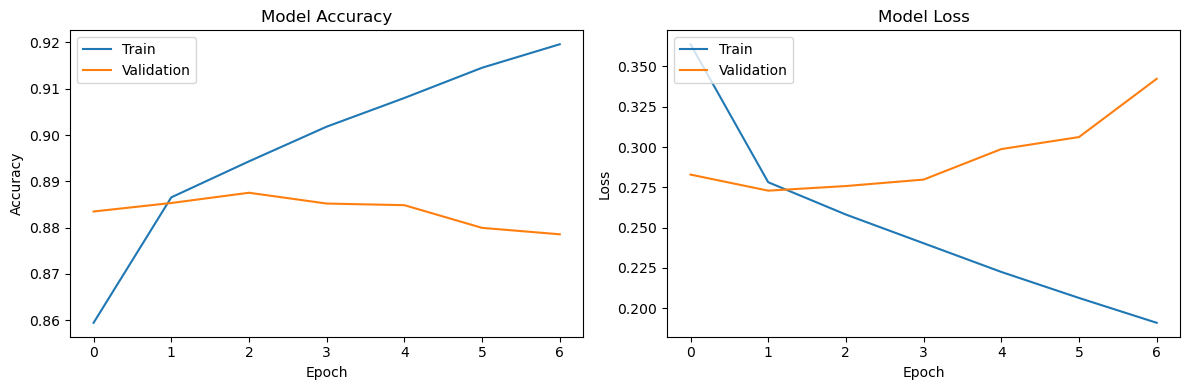

In [38]:
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

2896/2896 [==============================] - 77s 26ms/step


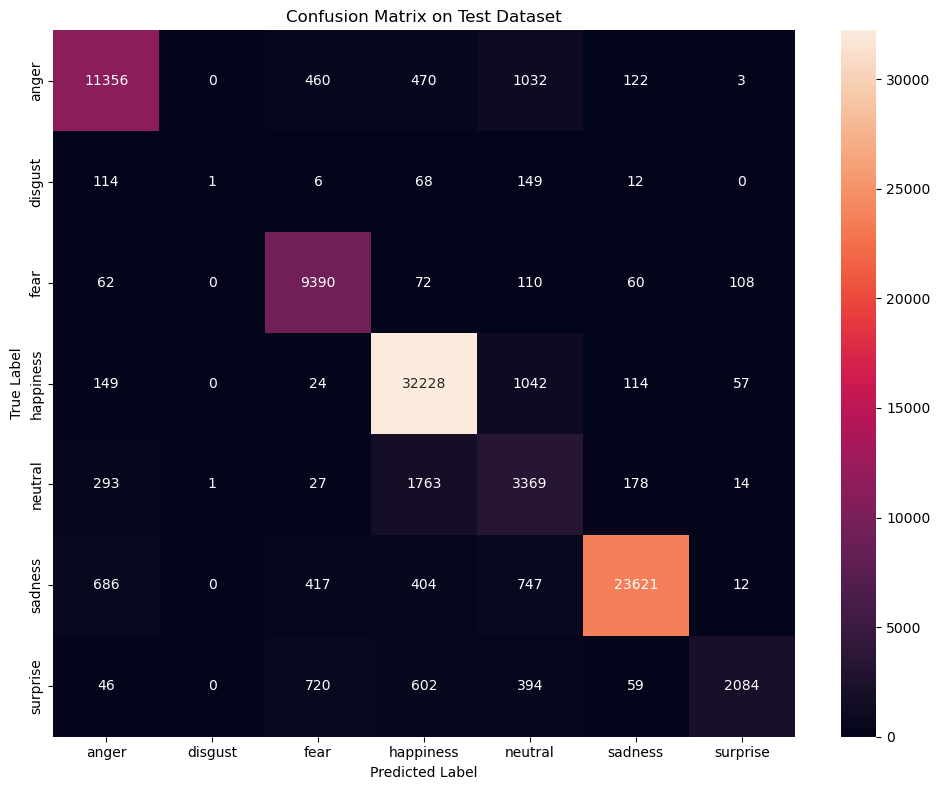


Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.84      0.87     13443
     disgust       0.50      0.00      0.01       350
        fear       0.85      0.96      0.90      9802
   happiness       0.91      0.96      0.93     33614
     neutral       0.49      0.60      0.54      5645
     sadness       0.98      0.91      0.94     25887
    surprise       0.91      0.53      0.67      3905

    accuracy                           0.89     92646
   macro avg       0.79      0.69      0.69     92646
weighted avg       0.89      0.89      0.88     92646

Weighted F1 Score: 0.8842


In [39]:
# Make predictions on test data
predictions = model.predict({
    'text_input': X_test_text,
    'sentiment_input': X_test_sentiment,
    'entity_input': X_test_entity,
    'pos_input': X_test_pos,
    'tfidf_input': X_test_tfidf,
    'glove_input': X_test_glove
})

# Get predicted emotion labels
predicted_emotions = np.argmax(predictions, axis=1)
true_emotions = np.argmax(y_test, axis=1)

# Generate confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(true_emotions, predicted_emotions)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix on Test Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(
    true_emotions,
    predicted_emotions,
    target_names=label_encoder.classes_
))

# Calculate overall F1 score
f1 = f1_score(true_emotions, predicted_emotions, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

In [40]:
# Load the external test dataset
test_df = pd.read_csv('group_24_url1.csv')
print("External test dataset loaded with shape:", test_df.shape)

External test dataset loaded with shape: (1041, 7)


In [41]:
# Map the granular emotions to the 7 main categories
complete_emotion_mapping = {
    "happiness": [
        "joy", "optimism", "approval", "pride", "gratitude",
        "love", "excitement", "caring", "relief", "admiration",
        "amusement", "desire"
    ],
    "sadness": [
        "disappointment", "remorse", "grief", "sadness"
    ],
    "anger": [
        "anger", "annoyance", "disapproval"
    ],
    "disgust": [
        "disgust", "embarrassment"
    ],
    "fear": [
        "fear", "nervousness"
    ],
    "surprise": [
        "surprise", "realization", "confusion", "curiosity"
    ],
    "neutral": [
        "neutral"
    ]
}

# Create a flat mapping dictionary for easy lookup
emotion_to_category = {}
for category, emotions in complete_emotion_mapping.items():
    for emotion in emotions:
        emotion_to_category[emotion.lower()] = category

# Apply the mapping to convert granular emotions to main categories
test_df['main_emotion'] = test_df['Emotion'].str.lower().map(emotion_to_category)

# Check for any unmapped emotions
unmapped = test_df[test_df['main_emotion'].isna()]['Emotion'].unique()
if len(unmapped) > 0:
    print(f"Warning: The following emotions were not mapped: {unmapped}")
    # Assign unmapped emotions to neutral or another appropriate category
    test_df['main_emotion'] = test_df['main_emotion'].fillna('neutral')

print("\nMapped main emotion distribution:")
print(test_df['main_emotion'].value_counts())


Mapped main emotion distribution:
main_emotion
neutral      354
anger        217
happiness    184
surprise     168
sadness       72
fear          42
disgust        4
Name: count, dtype: int64


In [42]:
# Map the emotions to IDs based on your specification
emotion_id_mapping = {
    'sadness': 1,
    'anger': 2,
    'disgust': 3,
    'fear': 4,
    'surprise': 5,
    'happiness': 6,
    'neutral': 7
}

# Convert to the model's expected format (0-indexed)
test_df['emotion_id'] = test_df['main_emotion'].map(emotion_id_mapping)
test_df['emotion_id_0based'] = test_df['emotion_id'] - 1

# Create one-hot encoded labels
test_y = tf.keras.utils.to_categorical(test_df['emotion_id_0based'], num_classes=len(emotion_id_mapping))

In [43]:
# Process text data - use 'Translation' column for English text
test_sequences = tokenizer.texts_to_sequences(test_df['Translation'].astype(str))
test_padded_sequences = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Create dummy features for the test set to match model inputs
test_sentiment_features = np.zeros((len(test_df), sentiment_features.shape[1]))
test_entity_features = np.zeros((len(test_df), entity_features.shape[1]))
test_pos_features = np.zeros((len(test_df), pos_features.shape[1]))
test_tfidf_features = np.zeros((len(test_df), tfidf_features.shape[1]))
test_glove_features = np.zeros((len(test_df), glove_features.shape[1]))

# Map intensity to sentiment if available
intensity_mapping = {
    'neutral': 0.0,
    'slight': 0.25,
    'moderate': 0.5,
    'intense': 1.0
}

if 'Intensity' in test_df.columns:
    test_df['intensity_score'] = test_df['Intensity'].map(intensity_mapping)
    test_sentiment_features = test_df['intensity_score'].fillna(0).values.reshape(-1, 1)

33/33 [==============================] - 1s 23ms/step


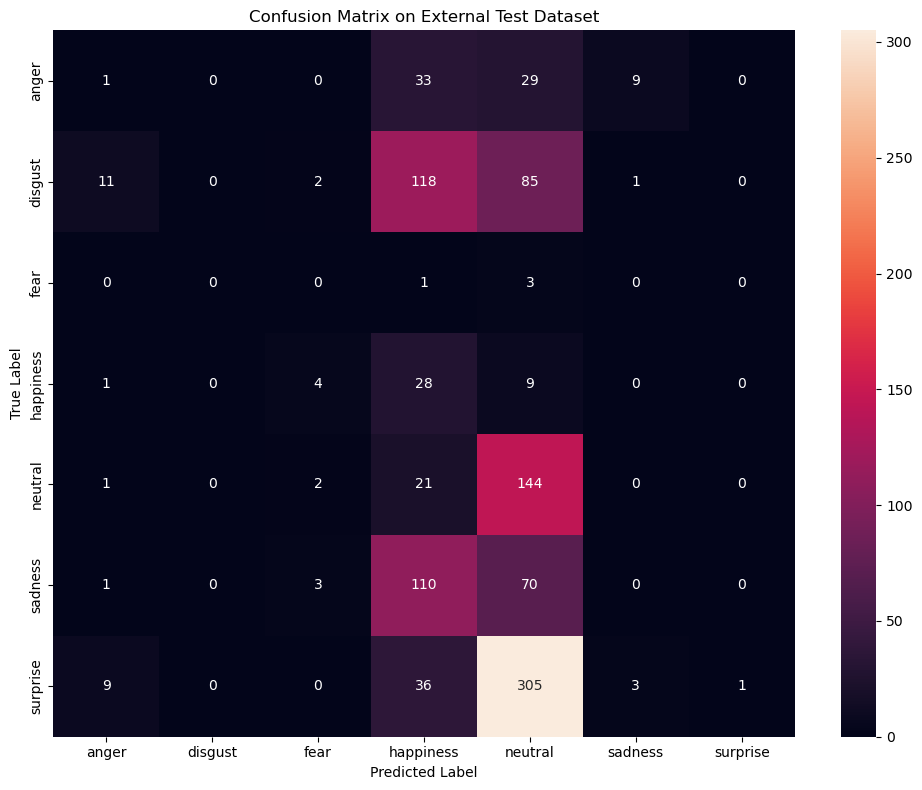

In [44]:
# Make predictions on the external test dataset
external_predictions = model.predict({
    'text_input': test_padded_sequences,
    'sentiment_input': test_sentiment_features,
    'entity_input': test_entity_features,
    'pos_input': test_pos_features,
    'tfidf_input': test_tfidf_features,
    'glove_input': test_glove_features
})

# Get predicted and true emotion labels
external_predicted_emotions = np.argmax(external_predictions, axis=1)
external_true_emotions = np.argmax(test_y, axis=1)

# Generate confusion matrix for external test data
plt.figure(figsize=(10, 8))
external_cm = confusion_matrix(external_true_emotions, external_predicted_emotions)
sns.heatmap(
    external_cm,
    annot=True,
    fmt='d',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Confusion Matrix on External Test Dataset')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [45]:
# Print classification report for external test data
print("\nClassification Report for External Test Dataset:")
print(classification_report(
    external_true_emotions,
    external_predicted_emotions,
    target_names=label_encoder.classes_
))

# Calculate F1 score for external test data
external_f1 = f1_score(external_true_emotions, external_predicted_emotions, average='weighted')
print(f"External Test Dataset - Weighted F1 Score: {external_f1:.4f}")


Classification Report for External Test Dataset:
              precision    recall  f1-score   support

       anger       0.04      0.01      0.02        72
     disgust       0.00      0.00      0.00       217
        fear       0.00      0.00      0.00         4
   happiness       0.08      0.67      0.14        42
     neutral       0.22      0.86      0.35       168
     sadness       0.00      0.00      0.00       184
    surprise       1.00      0.00      0.01       354

    accuracy                           0.17      1041
   macro avg       0.19      0.22      0.07      1041
weighted avg       0.38      0.17      0.07      1041

External Test Dataset - Weighted F1 Score: 0.0663


c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\35988\anaconda3\envs\BLock_C_Year_2\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [46]:
# Compare performance on original test set vs external test set
print("\nPerformance Comparison:")
print(f"Original Test Set F1 Score: {f1:.4f}")
print(f"External Test Set F1 Score: {external_f1:.4f}")
print(f"Difference: {abs(f1 - external_f1):.4f}")


Performance Comparison:
Original Test Set F1 Score: 0.8842
External Test Set F1 Score: 0.0663
Difference: 0.8179


In [47]:
# Add predictions to the dataframe
test_df['predicted_emotion_id'] = external_predicted_emotions + 1  # Convert back to 1-7 scale
test_df['predicted_emotion'] = test_df['predicted_emotion_id'].map({v: k for k, v in emotion_id_mapping.items()})

# Save results
test_df.to_csv('external_test_results.csv', index=False)
print("Results saved to 'external_test_results.csv'")

Results saved to 'external_test_results.csv'
